# Multispecies Eden model simulation and analysis tools in Python

In [6]:
# RUN ME
import numpy as np
from numba import jit, njit, int32, prange
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from ipywidgets import widgets
import time
from matplotlib import patches
from IPython.display import clear_output
%matplotlib widget
import random

my_int = int32

@njit
def jit_get_lineage(lattice, fpt):
    """ Calculate lineage backwards from given site """
    daughter = fpt
    lineage = np.empty((100,2), dtype=my_int)
    lineage[0,:] = daughter[:]
    lin_len = 1
    while True:
        mother = lattice[daughter[0],daughter[1],1:3]
        if np.all(mother == daughter): 
            break # stop when we find a site that's its own mother (meaning filled at t=0)
        lin_len += 1
        if lin_len > lineage.shape[0] - 1: # double array length if needed
            lineage = np.concatenate((lineage, np.empty_like(lineage)))
        lineage[lin_len-1,:] = mother[:] # append mother to lineage
        daughter = mother # find mother's mother next time
    return lineage[:lin_len] 
    
@njit
def get_frontier(fr, t, rates, lattice, n_nbors, nullval, nbors_list):
    """ Get all sites that are filled but 
    adjacent to an unfilled site at a given time """
    f_len = 0
    yx = np.full(2, 0)
    eligible_nbi = np.full(n_nbors, False)
    for y in range(lattice.shape[0]):
        yx[0] = y
        for x in range(lattice.shape[1]):
            yx[1] = x
            g = lattice[y,x,0]
            filltime = lattice[y,x,3]
            if g >= 0 and filltime <= t:
                if rates[g] > 0:
                    if get_empty_nbors(lattice, yx, nbors_list, eligible_nbi, nullval, before=t) > 0:
                        fr[f_len,:] = yx
                        f_len += 1
    return f_len     
    
@njit(fastmath=True, parallel=False)
def jit_timestep(lattice, frontier, frontier_len, 
                                nbors_list, eligible_nbi, t, nullval, rates, xy_rates,
                                do_n_steps = 1):
    """ Multiple loops over the update step happen here, random choices of mother and daughter """
    # do these things once per jit function call 
    max_g = np.max(lattice[:,:,0])
    do_stop = False
    frontier_rates = np.full(frontier.shape[0], 0.)
    for fi, (fy, fx) in enumerate(frontier[:frontier_len]):
        #!!! uncomment the below line (and comment out the one below that) when we have non-neutral evolution
#         frontier_rates[fi] = rates[lattice[fy, fx, 0]] * xy_rates[fy,fx]
        frontier_rates[fi] = xy_rates[fy,fx]
    # create array for cumulative sum of reproduction rates
    cs = np.full(frontier.shape[0], 0.) 
    cs[0] = frontier_rates[0]
    running_sum = 0 
    for i in range(frontier_len):
        running_sum = cs[i] = running_sum + frontier_rates[i]
    
    # loop over update step
    for step_n in range(do_n_steps):
        found_mother = False
        while frontier_len > 0 and not found_mother: # loop until found mother or exhaust all possibilities                        
            rndmtr = np.random.random() 
            nm = int(frontier_len*rndmtr) # reasonable guess
            rndmtr *= cs[frontier_len-1]
            
            if cs[nm] > rndmtr:
                while cs[nm] > rndmtr:
                    nm -= 1
                nm += 1
            else:                
                while cs[nm] <= rndmtr:
                    nm += 1                             
                        
            mother = frontier[nm] # mother's xy vals
            # find mother's empty neighbors:
            nd = get_empty_nbors(lattice, mother, nbors_list, eligible_nbi, nullval)
            if nd > 0: # if mother has ≥1 empty neighbor
                found_mother = True
                t += 1 
                daughter = nbors_list[mother[0],mother[1],eligible_nbi[np.random.randint(nd)]] # randomly select daughter
                copy_gene(lattice, mother, daughter, t) # fill daughter site                
                nd -= 1 # mother loses one empty neighbor                
                ndd = get_empty_nbors(lattice, daughter, nbors_list, eligible_nbi, nullval) # find how many of daughter's neighbors are empty 
                if ndd > 0: # add daughter to frontier if she has ≥ 1 empty neighbor                    
                    dy, dx = frontier[frontier_len] = daughter[:] # add daughter to frontier 
                    #!!! uncomment the below line (and comment out the one below that) when we have non-neutral evolution                    
#                     frontier_rates[frontier_len] = rates[lattice[dy, dx, 0]] * xy_rates[dy,dx]
                    frontier_rates[frontier_len] = xy_rates[dy,dx]
                    cs[frontier_len] = cs[frontier_len-1] + frontier_rates[frontier_len]  # append to cumulative sum 
                    frontier_len += 1
                
            if nd == 0: # either mother didn't belong in frontier, or we just filled her last empty neighbor
                # remove mother from frontier
                frontier_len -= 1
                frontier[nm] = frontier[frontier_len] # swap last element and element to be dropped
                # shift cumulative sum accordingly:
                cs_shift = -frontier_rates[nm]
                frontier_rates[nm] = frontier_rates[frontier_len]
                cs_shift += frontier_rates[nm]                
                # update cumulative sum starting at index of swapped mothers
                for i in range(nm, frontier_len):
                    cs[i] += cs_shift

        if frontier_len <= 0 or do_stop:
            break
    return frontier_len, t


@njit(fastmath=True)
def copy_gene(lattice, mother, daughter, t):
    dy, dx = daughter
    lattice[dy, dx, 0] = lattice[mother[0],mother[1],0] # copy gene label
    lattice[dy, dx, 1:3] = mother[:] # remember mother's xy location
    lattice[dy, dx, 3] = t # record time filled
    
    
@njit(fastmath=True)
def get_empty_nbors(lattice, site, nbors_list, eligible_nbi, nullval, before=np.inf):
    nb_list = nbors_list[site[0]][site[1]]
    nd = 0
    for nbi in range(nb_list.shape[0]):
        nby, nbx = nb_list[nbi] 
        if nby != nullval and nbx != nullval:
            if (lattice[nby,nbx,0] < 0 # if neighbor site is still unfilled 
                or lattice[nby,nbx,3] > before): # or neighbor site was filled after "before"
                eligible_nbi[nd] = nbi # mark this neighbor as eliible
                nd += 1     # increment tally of empty neighbors
    return nd

def sys_rnd_seed(n_iters=6):
    """ Get random integer from Bash's $RANDOM environment variable"""
#     sd=""
#     for i in range(n_iters):
#         instr=!echo $RANDOM
#         sd += instr[0]
#     sd=int(sd)
    return random.randint(0,  2**32 - 1)

@njit
def lin_msd_jit(lin, msd, msd_count, Lx):
    """ Calculate msd(x) of a given lineage"""
    xf = lin[-1,1]
    for i in range(len(lin)):
        val = lin[i,1] - xf
        if val <= -Lx/2:
            val += Lx
        elif val > Lx/2:
            val -= Lx
        val = val*val
        y = lin[i,0]
        msd[y] += val # dx_sq
        msd_count[y] += 1

        
@njit
def find_coal_time(flip1, flip2, lattice, t_coal_counts, t_ref):
    """ Find the coalescence time (in forward time) of two flipped lineages """
    max_idx = max(flip1.shape[0], flip2.shape[0])
    i=0
    while i < max_idx and flip1[i,0] == flip2[i,0] and flip1[i,1] == flip2[i,1]:
        i += 1
    i -= 1
    y, x = flip1[i]
    t_coal_counts[t_ref-lattice[y,x,3]] += 1



In [7]:
# RUN ME

class lattice_class:
    """ Abstract class were we fine the neighbors of each site """
    def __init__(self, Lx, Ly, n_data_int, lattice_type = 'hexagonal'):        
        self.lattice_type = lattice_type
        self.Lx = Lx
        self.Ly = Ly
        self.dim = 2
        self.nullval = -1        
        self.int_type = int
        self.get_nbors_list()
        self.lattice = np.zeros((Ly,Lx,n_data_int), dtype=self.int_type)
    
    def get_nbors_list(self):
        try:
            self.lattice_type in ['hexagonal', 'square']
        except:
            print("Unrecongized lattice type ", self.lattice_type)
        shp = (self.Ly, self.Lx)
        
        self.n_nbors = 6 if self.lattice_type == 'hexagonal' else 4
        self.nbors_list = np.full((self.Ly, self.Lx, self.n_nbors, self.dim), self.nullval, dtype=self.int_type )
        if self.lattice_type == 'hexagonal':
            for i in [0,1]:
                self.nbors_list[:,:,i,0] = np.fromfunction(lambda y,x: y, shp, dtype=self.int_type )
            self.nbors_list[:,:,0,1] = np.fromfunction(lambda y,x: (x-1)%self.Lx, shp, dtype=self.int_type )
            self.nbors_list[:,:,1,1] = np.fromfunction(lambda y,x: (x+1)%self.Lx, shp, dtype=self.int_type )
            for i in [2,3]:
                self.nbors_list[:,:,i,0] = np.fromfunction(lambda y,x: self.nullval*(y<=0) + (y-1)*(y>0), shp, dtype=self.int_type )
            self.nbors_list[:,:,2,1] = np.fromfunction(lambda y,x: ((x+1)%self.Lx)*(y%2!=0) + x*(y%2==0), shp, dtype=self.int_type ) # xup
            self.nbors_list[:,:,3,1] = np.fromfunction(lambda y,x: x*(y%2!=0) + ((x-1)%self.Lx)*(y%2==0), shp, dtype=self.int_type ) # xdn
            for i in [4,5]:
                self.nbors_list[:,:,i,0] = np.fromfunction(lambda y,x: self.nullval*(y>=self.Ly-1) + (y+1)*(y<self.Ly-1), shp, dtype=self.int_type )
            self.nbors_list[:,:,4,1] = np.fromfunction(lambda y,x: ((x+1)%self.Lx)*(y%2!=0) + x*(y%2==0), shp, dtype=self.int_type ) # xup
            self.nbors_list[:,:,5,1] = np.fromfunction(lambda y,x: x*(y%2!=0) + ((x-1)%self.Lx)*(y%2==0), shp, dtype=self.int_type ) # xdn
        elif self.lattice_type == 'square':
            for i in [0,1]:
                self.nbors_list[:,:,i,0] = np.fromfunction(lambda y,x: y, shp, dtype=self.int_type)             
            self.nbors_list[:,:,0,1] = np.fromfunction(lambda y,x: np.mod(x+1,self.Lx), shp, dtype=self.int_type) #xup 
            self.nbors_list[:,:,1,1] = np.fromfunction(lambda y,x: np.mod(x-1,self.Lx), shp, dtype=self.int_type)  #xdn
            for i in [2,3]:
                self.nbors_list[:,:,i,1] = np.fromfunction(lambda y,x: x, (self.Ly,self.Lx), dtype=self.int_type)                            
            self.nbors_list[:,:,2,0] = np.fromfunction(lambda y,x: self.nullval*(y>=self.Ly-1) + (y+1)*(y<self.Ly-1), shp, dtype=self.int_type ) #yup
            self.nbors_list[:,:,3,0] = np.fromfunction(lambda y,x: self.nullval*(y<=0) + (y-1)*(y>0), shp, dtype=self.int_type ) #ydn


class realization(lattice_class):
    """ creates a stepping-stone world that we can use for multiple runs """
    def __init__(self, Lx, Ly, figsize=6, ptsize=1, lattice_type='hexagonal'):
        super().__init__(Lx,Ly,4, lattice_type=lattice_type)
        self.nogene = -self.Lx
        self.figsize = figsize
        self.ptsize = ptsize
        self.rates = np.empty(self.Lx*self.Ly)
        self.n_hotspots = 0
        self.hotspot_centers = np.empty((self.n_hotspots,2))
        self.hotspot_strengths = 1
        self.hotspot_radii = 10
        self.xy_rates = np.ones((self.Ly,self.Lx))
        
    def reset(self): 
        """ prepare world for a new run, including the first time """
        self.t = 0
        self.initialize_lattice()
        self.ngenes = np.max(self.lattice[:,:,0])
        self.eligible_nbi = np.empty(self.n_nbors, dtype=int)
        self.rates[:1+self.ngenes] = 1.
        self.frontier, self.frontier_len = self.get_frontier(1)   
        
    def initialize_lattice(self):
        self.lattice[0,:,0] = np.arange(self.Lx) # unique gene for every site at y=0
        self.lattice[1:,:,0] = self.nogene # all other sites empty
        self.lattice[0,:,1:3] = -1 # nonsense marker for mother-info of unfilled sites
        self.set_self_mother() # mark filled sites as their own mothers
        
    def set_self_mother(self):
        """ (For initialization) set occupied sites to be their own mother """
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.lattice[y,x,0] != self.nogene:
                    self.lattice[y,x,1] = y
                    self.lattice[y,x,2] = x
    
    def set_xy_rates(self, from_hotspots=True, from_arr=None):
        """ set spatial dependence of reproduction rate, either from an explicit array or from a set of hotspots """
        if from_hotspots:
            for hy, hx in self.hotspot_centers:
                self.xy_rates *= np.fromfunction(lambda y,x: 
                                1 + (-1+self.hotspot_strengths) * (
                                    (np.mod(y-hy + self.Ly/2, self.Ly) - self.Ly/2)**2 + (np.mod(x-hx + self.Lx/2, self.Lx) - self.Lx/2)**2 < self.hotspot_radii**2
                                ), (self.Ly, self.Lx)
                )                
        if from_arr is not None:
            self.xy_rates *= from_arr
            
    def timestep(self, do_n_steps = 1):        
        self.frontier_len, self.t = jit_timestep(
            self.lattice, self.frontier, self.frontier_len, self.nbors_list, 
            self.eligible_nbi, self.t, self.nullval, self.rates, self.xy_rates,
            do_n_steps = do_n_steps)
    
    def run(self, seed=None, jit_loops = -1, initialize=True):
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)        
        if initialize:
            self.reset()
            self.setup_fig()            
        if jit_loops < 0:
            jit_loops = int(self.Lx*self.Ly/10) # default
        while self.frontier_len > 0:
            print(f'\r{int(100*np.sum(self.lattice[:,:,0]>=0)/(self.Lx*self.Ly))}%\t\r', end='\r', flush=True)
            self.timestep(do_n_steps = jit_loops)
            time.sleep(1e-10)
        print("\rDone")
                 
    def get_genes(self, before=np.inf):
        # set unfilled to -1 in returned array
        tmp = (self.get_filltimes() <= before)
        return (self.lattice[:,:,0] * tmp + (tmp-1))

    def get_filltimes(self):
        return self.lattice[:,:,3]

    def get_frontier(self, t = np.inf):
        fr = np.empty((self.Ly*self.Lx,self.dim), dtype=int)
        f_len = get_frontier(fr, t, self.rates, self.lattice, self.n_nbors, self.nullval, self.nbors_list)
        return fr, f_len 
    
    def clean_frontier(self, t=np.inf):
        """ remove from frontier sites with no empty neighbors left """
        new_frontier = np.empty_like(self.frontier)
        new_frontier_len = 0
        for fpt in self.frontier[:self.frontier_len]:
            if self.num_empty_nbors(fpt, before=t) > 0:
                new_frontier[new_frontier_len,:] = fpt
                new_frontier_len += 1
        self.frontier = new_frontier
        self.frontier_len = new_frontier_len 
    
    def get_lineage(self, fpt):
        return jit_get_lineage(self.lattice, fpt)
    
    def get_lineages(self, tf):
        f, f_len = self.get_frontier(tf)
        self.lineages = [ self.get_lineage(fpt) for fpt in f[:f_len] ]
        return self.lineages
    
    def lineage_msd(self, tf):
        lins = self.get_lineages(tf)
        msd = np.zeros(self.Ly)
        msd_count = np.full(self.Ly, 0)
        for lin in lins:
            lin_msd_jit(lin, msd, msd_count, self.Lx)
        msd /= (msd_count + (msd_count==0))
        return msd
        
    def setup_fig(self, randomize_colors = True, orientation='vertical', figsize=None, ptsize=None):
        import matplotlib.pyplot as plt
        self.fig_orientation = orientation
        if figsize is not None:
            self.figsize = figsize
        if ptsize is not None:
            self.ptsize = ptsize
        vmax = self.ngenes
        color_permut_func = np.random.permutation if randomize_colors else lambda x: x
        newcmp = ListedColormap(
            color_permut_func(
                np.array([ mpl.colors.hsv_to_rgb((val/vmax,1,1)) 
                      for val in range(vmax) ])
            )
        )
        newcmp.set_under(color='black')
        newcmp.set_over(color='black')
        newcmp.set_bad(color='black')
        newcmp.set_extremes()
        
        plt.ioff()
        self.fig, self.ax = plt.subplots(figsize=(self.figsize,self.figsize));
        self.fig.tight_layout();
        
        aspect=np.sqrt(3) if self.lattice_type == 'hexagonal' else 1
        if orientation == 'horizontal':
            aspect = 1/aspect
            
        self.gene_img = self.ax.imshow(
            self.hex_lattice_for_plot(self.get_genes()), 
            vmin=0, vmax=vmax,
            cmap = newcmp,
            interpolation = 'nearest',
            aspect=aspect
        );

        xfactor = (2 if self.lattice_type=='hexagonal' else 1)
        
        x_lim = [0,xfactor*(self.Lx-1)]
        y_lim = [0,self.Ly-1]
        if orientation=='horizontal':
            x_lim, y_lim = (y_lim, x_lim)
        self.ax.set_xlim(x_lim)
        self.ax.set_ylim(y_lim)
        if orientation=='horizontal':
            self.ax.set_yticks(self.ax.get_yticks()) # useless line that silences a warning
            self.ax.set_yticklabels([ str(tk) for tk in np.asarray(self.ax.get_yticks()/xfactor, dtype=int) ])
        else:
            self.ax.set_xticks(self.ax.get_xticks()) # useless line that silences a warning        
            self.ax.set_xticklabels([ str(tk) for tk in np.asarray(self.ax.get_xticks()/xfactor, dtype=int) ])
        plt.ion()
    
    def place_hotspots_randomly(self):
        boxsize = np.array([self.Ly,self.Lx])
        while self.hotspot_centers.shape[0] < self.n_hotspots:            
                new_hyx = self.hotspot_radii + ((boxsize-2*self.hotspot_radii) * np.random.random(2))
                good_new_hyx = True
                for old_hyx in self.hotspot_centers:
                    dist_sq = np.sum((np.mod((new_hyx - old_hyx + 0.5*boxsize), boxsize) - 0.5*boxsize)**2)
                    if dist_sq < (2*self.hotspot_radii)**2:
                        good_new_hyx = False
                        break # try again 
                if good_new_hyx:        
                    self.hotspot_centers = np.concatenate((self.hotspot_centers, np.array([new_hyx])))
                    print(f"\r{self.hotspot_centers.shape[0]} of {self.n_hotspots} hotspots placed\r", end="\r", flush=True)
        self.set_xy_rates()
        print("\n")
                    
    def pickle(self, name=None):
        """ save the whole world (can be very large file!) """
        import pickle
        import glob
        if name is None:
            fout_name = "pickle/u" + str(
                1+max(
                    [ int(item.split("pickle/u")[-1].split(".p")[0]) 
                     for item in glob.glob("pickle/u*.p") 
                    ]
                )
            ) + ".p"
        else:
            fout_name = name
        pickle.dump(u, open(fout_name, "wb"))   
        print(" > " + fout_name)
        
    def hex_lattice_for_plot(self, arr):
        """ some tricks to plot hexagonal array data on a square grid """
        if self.lattice_type == 'hexagonal':
            dat2 = np.stack((arr,arr), axis=-1).reshape(arr.shape[0],arr.shape[1]*2)
            for y in range(1,arr.shape[0],2):
                dat2[y,:] = np.roll(dat2[y],1)
        else:
            dat2 = arr
        if self.fig_orientation=='horizontal':
            dat2 = dat2.T
        return dat2
        
    def hex_scatter_xs(self, xs, ys):
        """ some tricks to plot scatter points from a hexagonal array on a square grid """
        if self.lattice_type == 'hexagonal':
            return np.minimum(0.5 + 2*xs + (ys%2 == 1), 2*self.Lx)
        else:
            return xs
      
    def look(self, t=np.inf, show_genes=True, show_lineages=False, 
             show_frontier=False, show_hotspots=False, recalc_lineages=True,
            show_xy_rates = False):
        """ plot the state of the world at a given time """
        if show_genes:
            self.gene_img.set_data(self.hex_lattice_for_plot(self.get_genes(before=t)))
        else:
            self.gene_img.set_data(np.empty((0,0)))
        if show_lineages:
            self.plot_lineages(t=t, recalc_lineages=recalc_lineages)
        if show_frontier:
            self.plot_frontier(t=t)
        if show_hotspots:
            asp = self.ax.get_aspect()
            xfactor = 2 if self.lattice_type == 'hexagonal' else 1
            for y, x in self.hotspot_centers:
                self.ax.add_patch(patches.Ellipse(np.array([xfactor*x, y]),#self.Ly-1-y]),
                                                  2*self.hotspot_radii*asp, 2*self.hotspot_radii, color='grey', alpha=0.5))            
        if show_xy_rates:
            self.ax.imshow( (lambda thing: thing.T if self.fig_orientation=='horizontal' else thing)(self.xy_rates), cmap='Reds', alpha=0.75)
        return self.fig
    
    def plot_frontier(self, t=np.inf):
        fpx, fpy = self.frontier_pts_to_plot(t=t)
        self.frontier_img = self.ax.scatter(fpx, fpy, c = 'white', s=self.ptsize)
    
    def t_hit_top(self):
        """ time when frontier first reaches y=ymax; a good choice for calculating lineages """
        return np.min(self.lattice[-1,:,3])
        
    def frontier_pts_to_plot(self, t=np.inf):
        f, f_len = self.get_frontier(t=t)
        f = f[:f_len]
        xs = f[:,1]
        ys = f[:,0]
        xs = self.hex_scatter_xs(xs, ys) 
        if self.fig_orientation=='horizontal':
            xs, ys = (ys, xs)
        return xs, ys
            
    def get_linlocs(self, t=np.inf, recalc_lineages=True):
        """ turn set of lineages into a matrix of number-of-lineages-per-site """
        if recalc_lineages:
            lins = self.get_lineages(t)        
        else:
            lins = self.lineages
        self.lins_arr = np.full((self.Ly,self.Lx), 0)        
        for lin in lins:
            lys, lxs = lin.T
            self.lins_arr[lys, lxs] += 1
        lys, lxs = np.where(self.lins_arr)
        n_hits = self.lins_arr[lys, lxs]
        return np.array([lys, lxs, n_hits]).T
    
    def get_t_coal_counts(self, t_ref, recalc_lineages=False):
        """ Coalescence times """        
        if recalc_lineages:
            self.get_lineages(t_ref)
        lins = self.lineages # assume we have calculated this previously
        t_coal_pairs = 0    
        t_coal_counts = np.full(self.Lx*self.Ly,0)
        flip_lins = [ np.flip(lin, axis=0) for lin in lins ]
        for lin1i in range(len(lins)):
            print(f"\r{t_coal_pairs / (len(lins)**2/2) * 100 :.0f}%\r", end="\r", flush=True)
            lin1 = flip_lins[lin1i]
            for lin2i in range(lin1i, len(lins)):
                lin2 = flip_lins[lin2i]
                if np.all(lin1[0] == lin2[0]):    
                    find_coal_time(lin1, lin2, self.lattice, t_coal_counts, t_ref)# t_coal_locs, n_t_coal_locs)
                t_coal_pairs += 1
        return t_coal_counts
        
    def plot_lineages(self, t=np.inf, recalc_lineages = True):   
        ys, xs, _ = self.get_linlocs(t=t, recalc_lineages=recalc_lineages).T
        xs = self.hex_scatter_xs(xs,ys) 
        if self.fig_orientation=='horizontal':
            xs, ys = (ys, xs)
        self.ax.scatter(xs, ys, c='black', s=1, marker=".")

Done


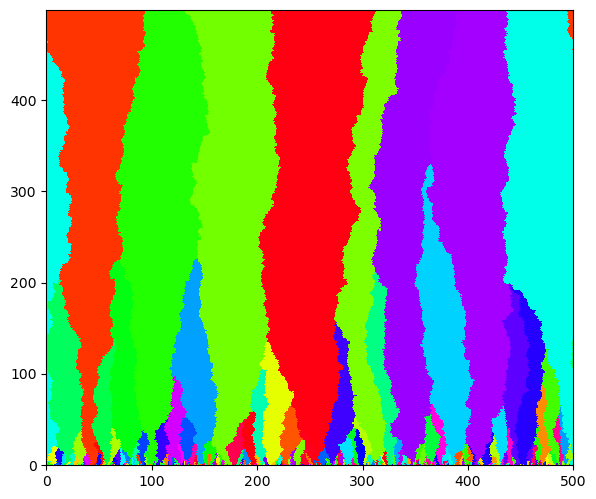

In [5]:
""" Basic usage """
u = realization(500,500) # (Lx,Ly)
u.run() # includes initialization 
u.look()

238 of 238 hotspots placed

Done


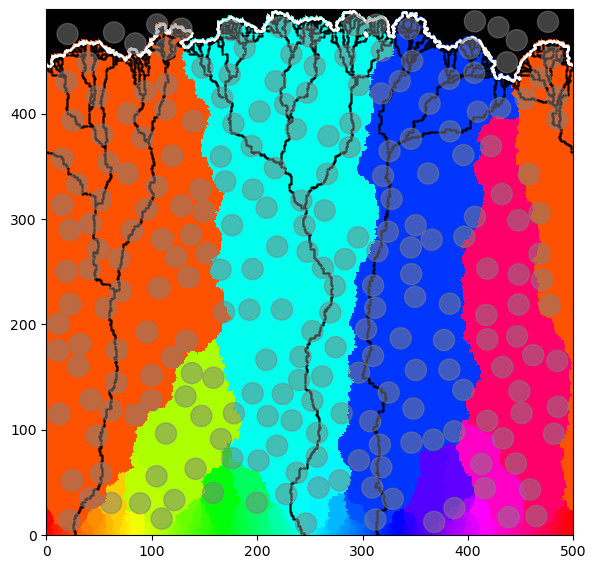

CPU times: user 12.3 s, sys: 227 ms, total: 12.6 s
Wall time: 12.4 s


In [9]:
%%time
""" Basic usage with auto-generated hotspots """
np.random.seed(2) 
u = realization(500,500, lattice_type='square')
u.reset()
hotspot_density = 0.3
u.hotspot_radii = 10
u.n_hotspots = int(hotspot_density * u.Lx*u.Ly/(np.pi*u.hotspot_radii**2))
u.hotspot_strengths = 3
u.place_hotspots_randomly()
u.run(initialize=False, seed=np.random.seed(2))
u.setup_fig(randomize_colors=False)
u.look(t=u.t_hit_top(), show_hotspots=True, show_lineages=True, show_frontier=True)
display(u.fig)
# run again
# u.reset()
# u.run(initialize=False, seed=np.random.seed(5))
# u.look(t=u.t_hit_top(), show_hotspots=True, show_lineages=True)
# display(u.fig)

In [67]:
""" Procedure for doing the runs. Executed in subsequent cell. """

import glob 

# landscape_folder = "/home/dbeller/range/its_a_rough_world/stepping_stone_code/landscapes/LandscapesForDan/"
landscape_folder = "/mnt/storage/shared/landscapes/LandscapesForDan/"
landscapes_path = landscape_folder + "landscape_files/"
savepath = "/mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/"
rpath =  savepath + "results/" 
analysis_path = savepath + "analysis/stats/"
imgpath = savepath + "analysis/images/"

n_runs_per_landscape = 5
run_index_start = 0

def the_whole_shebang(landscape_idx):
    """ For each speedmatrix landscape in a folder, do several runs and calculate (and plot) some lineage statistics """ 
    if landscape_idx == -1:
        landscape_fname = "landscape2dan_0.000000"
#     else:
#         landscape_fpath = glob.glob(f"{landscapes_path}/*.npz")[landscape_idx]
#         landscape_fname = landscape_fpath.split("/")[-1].split(".npz")[0]    
#     with np.load(landscape_fpath) as data:
#         landscape = data['speedmatrix']
    landscape = np.ones((500, 20250))
    print(landscape.size)
    Lx, Ly = landscape.shape
    u = realization(Lx, Ly, lattice_type='square')
    u.set_xy_rates(from_hotspots = False, from_arr = landscape.T)

    
        
    
    for f_idx in range(run_index_start, n_runs_per_landscape):
        u.reset()
        sd = sys_rnd_seed(2)
        np.random.seed(sd)
        u.run(initialize=False)
        fout_prefix = rpath+landscape_fname+"_run_"+f"{f_idx:3d}".replace(" ","0")
#         print(f"saving to {fout_prefix}")
        t_ref = u.t_hit_top()
        msd = u.lineage_msd(t_ref)
        linlocs = np.array(u.get_linlocs(t=t_ref, recalc_lineages=False))
        t_coal_counts = u.get_t_coal_counts(t_ref)
        np.savez_compressed(fout_prefix + "_stats.npz",                         
                            linlocs = linlocs, 
                            msd=msd, 
                            t_coal_counts = t_coal_counts, 
                            seed=np.array([sd]), 
                            t_ref = np.array([t_ref]))
        np.savez_compressed(fout_prefix + "_lattice.npz", lattice = u.lattice)
        print("\n",fout_prefix)
        

In [26]:
import glob

landscape_fpath = glob.glob()
print(landscape_fpath)

['/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.025000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.015000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.005000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.500000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.700000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.300000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.050000.npz', '/mnt/storage/shared/landscapes/LandscapesForDan/landscape_files/landscape2dan_0.150000.npz']


In [68]:
""" Do runs on each landscape in parallel """
the_whole_shebang(-1)
# from multiprocessing import Pool

# if __name__ == '__main__':
#     with Pool(8) as p:
#         p.map(the_whole_shebang, range(8))

10125000
Done
100%
 /mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/results/landscape2dan_0.000000_run_000
Done
100%
 /mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/results/landscape2dan_0.000000_run_001
Done
100%
 /mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/results/landscape2dan_0.000000_run_002
Done
100%
 /mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/results/landscape2dan_0.000000_run_003
Done
100%
 /mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/results/landscape2dan_0.000000_run_004


In [53]:
# from glob import glob
# i=0
# while True:
#     if len(glob.glob(f"{rpath}/*{i}_lattice*")) < 8:
#         print(i)
#         break

In [69]:
""" Summary statistics calculations on ensembles for each landscape (executed in next cell) """

import glob
# landscape_folder = "/home/dbeller/range/its_a_rough_world/stepping_stone_code/landscapes/LandscapesForDan/"
landscape_folder = "/mnt/storage/shared/landscapes/LandscapesForDan/"
landscapes_path = landscape_folder + "landscape_files/"
savepath = "/mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/"
rpath =  savepath + "results/" 
analysis_path = savepath + "analysis/stats/"
imgpath = savepath + "analysis/images/"

lnames = [ fn.split("/")[-1].split(".npz")[0] for fn in glob.glob(landscape_folder+"landscape_files/*") ]
plt.ioff()
def analyze_lin_stats(landscape_filename):
    npznames = glob.glob(landscape_folder + "results/" + landscape_filename + "*stats.npz")
    landscape = np.load(landscape_folder + "landscape_files/" +  landscape_filename + ".npz")["speedmatrix"]
    print(landscape_filename, len(npznames))
    Lx, Ly = landscape.shape
    linlocs = np.full((Ly,Lx),0)    
    for fname in npznames:
        print(f"\r{fname}\r", end="\r", flush=True)
        ll = np.load(fname)["linlocs"]
        linlocs[ll[:,0],ll[:,1]] += ll[:,2]
    linloc_frac = linlocs / np.sum(linlocs[0])
    fig, ax = plt.subplots(figsize=(32,5))
    im = ax.imshow(linloc_frac.T, vmax=np.max(linloc_frac)/5)
    cb = plt.colorbar(im, orientation='horizontal', shrink=0.1)
    ax.imshow(landscape, cmap="Reds", alpha=0.1)
    fig.tight_layout()
    ax.set_title(landscape_filename+" lineage locations")
    plt.savefig(imgpath + "linlocs/" + landscape_filename + "_linlocs.png")
    plt.close()

    msds = [ np.load(npzfile)["msd"] for npzfile in npznames ] 
    msd_len = np.min([ len(msd) for msd in msds ])
    msd_tot = np.sum(np.array([ msd[:msd_len] for msd in msds ]), axis=0) / len(msds)
    fig, ax = plt.subplots()
    ts = np.arange(len(msd_tot))
    ax.loglog(ts, msd_tot)
    ax.loglog(ts, ts**(4/3))
    ax.legend(["lineage_msd", r"$t^{4/3}$"], fontsize=12)
    ax.set_xlabel("timestep", fontsize=12)
    ax.set_ylabel("msd", fontsize=12)
    ax.set_title("Landscape: " + landscape_filename + "\n Lineage msds")
    plt.savefig(imgpath + "linmsd/" + landscape_filename + "_linmsd.png")
    plt.close()    
    
    t_coal_counts = np.load(npznames[0])["t_coal_counts"]
    for fname in npznames[1:]:
        t_coal_counts += np.load(fname)["t_coal_counts"]
    t_coal_binsize = 500000
    nbins = 1+int(t_coal_counts.shape[0]/t_coal_binsize)
    t_coal_counts_2 = np.concatenate((t_coal_counts/np.sum(t_coal_counts), np.full(t_coal_binsize*nbins - t_coal_counts.shape[0], 0) ))
    t_coal_bins = np.sum(t_coal_counts_2.reshape(nbins, t_coal_binsize),axis=1) 
    t_coal_bins = t_coal_bins[:1+np.max(np.argwhere(t_coal_bins))] # remove useless zeros at large t
    fig, ax = plt.subplots()
    ax.plot(
        np.arange(t_coal_bins.shape[0]), 
        t_coal_bins / t_coal_binsize
    )
    ax.set_xlabel(r"$\tau$ (x " + str(t_coal_binsize) + " timesteps)", fontsize=12)
    ax.set_ylabel(r"$P(\tau)$", fontsize=12)
    ax.set_title(landscape_filename+"\nCoalescence time probability")
    plt.savefig(imgpath + "t_coal/" + landscape_filename + "_t_coal.png")
    plt.close()  
    
    np.savez_compressed(analysis_path + landscape_filename + "_summary_stats.npz", 
        msd = msd,
        linloc_frac=linloc_frac,
        t_coal_counts=t_coal_counts
    )

In [70]:
""" Do analysis on each landscape in parallel """

from multiprocessing import Pool

if __name__ == '__main__':
    with Pool(8) as p:
        p.map(analyze_lin_stats, lnames[5:])

landscape2dan_0.150000landscape2dan_0.300000landscape2dan_0.050000   000




<ipython-input-69-e6848e5eee15>:24: RuntimeWarning: invalid value encountered in true_divide
  linloc_frac = linlocs / np.sum(linlocs[0])
<ipython-input-69-e6848e5eee15>:24: RuntimeWarning: invalid value encountered in true_divide
  linloc_frac = linlocs / np.sum(linlocs[0])
<ipython-input-69-e6848e5eee15>:24: RuntimeWarning: invalid value encountered in true_divide
  linloc_frac = linlocs / np.sum(linlocs[0])


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/storage/jgonzaleznunez/lineage-landscapes/danscode/analysis/images/linlocs/landscape2dan_0.150000_linlocs.png'

Below are some other utilities for getting lineage statistics from auto-generated hotspot landscapes 

In [ ]:
def make_lin_sets(u, num_hotspot_sets, num_runs_per_hotspot_set, n_hotspots, hotspot_radii, hotspot_strengths):
    u.reset()
    u.n_hotspots = n_hotspots
    u.hotspot_radii = hotspot_radii
    u.hotspot_strengths = hotspot_strengths
    print("density", u.n_hotspots*np.pi*u.hotspot_radii**2/(u.Ly*u.Lx))
    lin_sets = []
    for hi in range(num_hotspot_sets):
        print(f"---- {hi} ----")
        u.place_hotspots_randomly()
        hotspots = u.hotspot_centers    
        for ri in range(num_runs_per_hotspot_set):
                sd = ""
                for i in range(2):
                    tmp = !echo $RANDOM
                    sd += tmp[0]
                sd = int(sd)
                u.reset()            
                u.hotspot_centers = hotspots
                u.n_hotspots = n_hotspots
                u.hotspot_radii = hotspot_radii
                u.hotspot_strengths = hotspot_strengths
                u.set_xy_rates()
                u.run(seed=sd, initialize=False)    
                if ri == 0:
                    u.look(show_hotspots=True)
                    dfig = u.fig
                    display(dfig)
                lin_sets.append(u.get_lineages(u.Lx*u.Ly*0.75))
                print(f"  {ri}")
        clear_output()
    return lin_sets

def get_msd_all_lins(lin_sets, u):
    self=u
    all_lins = [ lin for lin_set in lin_sets for lin in lin_set ]
    msd = np.zeros(self.Ly)
    msd_count = np.zeros(self.Ly, dtype=int)
    for lin in all_lins:
        tmp = np.flip(lin - lin[-1],axis=0)
        tmp[:,1] += self.Lx*(tmp[:,1] < -self.Lx/2) - self.Lx*(tmp[:,1] > self.Lx/2)
        tmp[:,1] **= 2
        for y, dxsq in tmp:
            msd[y] += dxsq
            msd_count[y] += 1
    msd /= (msd_count + (msd_count==0))
    rnd_lbl = np.random.randint(100000)
    return msd, rnd_lbl

def make_msd_fig(msd, u, num_runs_per_hotspot_set, num_hotspot_sets, n_hotspots, hotspot_radii, hotspot_strengths, rnd_lbl):
    fig, ax = plt.subplots()
    ax.loglog(msd);
    ts = np.arange(msd.shape[0])
    vals = ts**(4/3)
    refcol = "orange"
    ax.loglog(ts, vals, c=refcol)
    ax.set_xlabel("timesteps", fontsize=12)
    ax.set_ylabel("lineage msd", fontsize=12)
    ax.set_title(f"{num_runs_per_hotspot_set}x{num_hotspot_sets} runs @ {n_hotspots}x[r={hotspot_radii},s={hotspot_strengths}] hotspots on {u.Lx}x{u.Ly} lattice")
    plt.savefig("Analysis/Images/" + str(rnd_lbl) + "_msd.png") # use random integer for saving files 
    np.savetxt("Analysis/Data/" + str(rnd_lbl) + "_msd.dat", msd)